# 📊 Predicting Hospital Readmissions within 30 Days

Hospital readmissions within 30 days are a critical healthcare concern, 
as they not only indicate complications in patient care but also 
lead to increased medical costs. 

This project aims to **predict whether a diabetic patient will be 
readmitted within 30 days after discharge**, using machine learning 
models trained on the *Diabetic Patient Dataset*.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## 1️⃣ Load Dataset

We load the **diabetic patient dataset** and check the initial shape.



In [34]:
df = pd.read_csv("diabetic_data.csv")
print("Initial Shape:", df.shape)



Initial Shape: (77599, 50)


## 2️⃣ Data Cleaning & Preprocessing

- Replace missing values (`?`) with NaN  
- Encode target variable:  
  - `<30` → 1 (Readmitted within 30 days)  
  - `>30` or `NO` → 0 (Not readmitted within 30 days)  
- Drop columns with >50% missing values  
- Fill missing values with mode  
- Convert categorical columns into dummy variables


In [38]:
df.replace('?', np.nan, inplace=True)

df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Final Shape after preprocessing:", df.shape)
print(df.head())


Final Shape after preprocessing: (77599, 2298)
   encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
0       2278392      8222157                6.0                      25.0   
1        149190     55629189                1.0                       1.0   
2         64410     86047875                1.0                       1.0   
3        500364     82442376                1.0                       1.0   
4         16680     42519267                1.0                       1.0   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                  1.0               1.0                41.0             0.0   
1                  7.0               3.0                59.0             0.0   
2                  7.0               2.0                11.0             5.0   
3                  7.0               2.0                44.0             1.0   
4                  7.0               1.0                51.0             0.0   

   num_me

## 3️⃣ Save Preprocessed Data



In [44]:
df.to_csv("preprocessed_diabetic_data.csv", index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'")


✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'


## 4️⃣ Exploratory Data Analysis (EDA)

We visualize:
- Class balance (Readmitted vs Not)  
- Age distribution  
- Hospital stay distribution


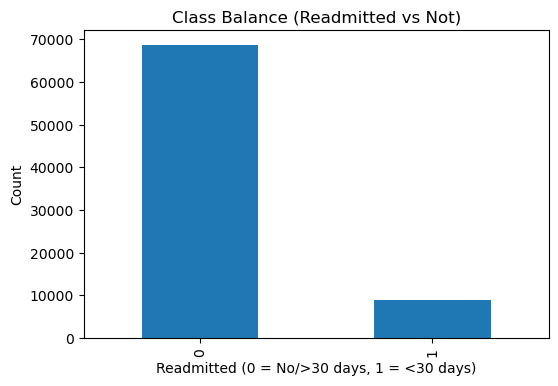

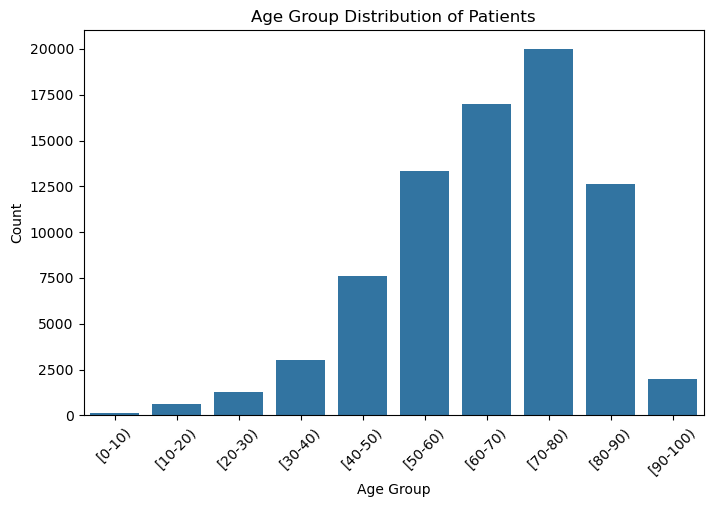

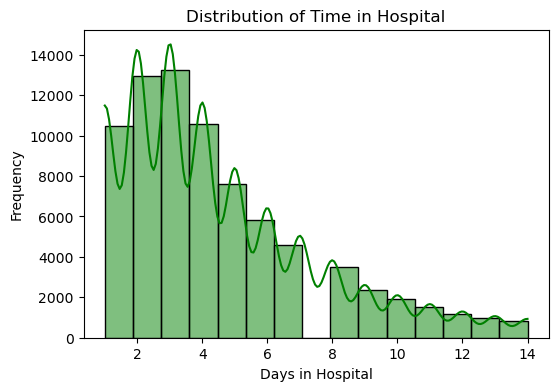

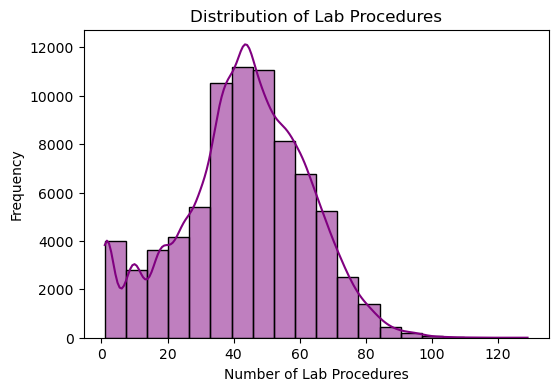

In [62]:

# Class balance (from processed df, since it's numeric)
plt.figure(figsize=(6,4))
df['readmitted'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Balance (Readmitted vs Not)")
plt.xlabel("Readmitted (0 = No/>30 days, 1 = <30 days)")
plt.ylabel("Count")
plt.show()

# ---- Load raw dataset ----
raw_df = pd.read_csv("diabetic_data.csv")

# Clean missing values in raw (to keep consistency)
raw_df.replace('?', np.nan, inplace=True)
raw_df.fillna(raw_df.mode().iloc[0], inplace=True)

# Age group distribution (from raw_df before encoding)
plt.figure(figsize=(8,5))
sns.countplot(x="age", data=raw_df, order=sorted(raw_df['age'].unique()))
plt.title("Age Group Distribution of Patients")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Distribution of time in hospital
plt.figure(figsize=(6,4))
sns.histplot(df['time_in_hospital'], bins=15, kde=True, color="green")
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.show()

# Distribution of number of lab procedures
plt.figure(figsize=(6,4))
sns.histplot(df['num_lab_procedures'], bins=20, kde=True, color="purple")
plt.title("Distribution of Lab Procedures")
plt.xlabel("Number of Lab Procedures")
plt.ylabel("Frequency")
plt.show()


## 5️⃣ Train-Test Split

In [65]:
from sklearn.model_selection import train_test_split

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (62079, 2297)
Test shape: (15520, 2297)


## 6️⃣ Feature Selection

We perform:
- Variance Threshold (remove low variance features)  
- Mutual Information (select top 30 features)  

In [68]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer

X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test[X_train_num.columns]

imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_imp = pd.DataFrame(imp.transform(X_test_num), columns=X_train_num.columns, index=X_test.index)

vt = VarianceThreshold(threshold=0.0)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_imp), columns=X_train_imp.columns[vt.get_support()], index=X_train_imp.index)
X_test_vt = pd.DataFrame(vt.transform(X_test_imp), columns=X_train_imp.columns[vt.get_support()], index=X_test_imp.index)

K_TOP_FEATURES = 30
k = min(K_TOP_FEATURES, X_train_vt.shape[1])
skb = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_sel = pd.DataFrame(skb.fit_transform(X_train_vt, y_train),
                           columns=X_train_vt.columns[skb.get_support()],
                           index=X_train_vt.index)
X_test_sel = pd.DataFrame(skb.transform(X_test_vt),
                          columns=X_train_vt.columns[skb.get_support()],
                          index=X_test_vt.index)

print(f"✅ Selected Top {k} Features")


✅ Selected Top 13 Features


### 🔍 Top Features by Mutual Information

C:\Users\user\AppData\Local\Temp\ipykernel_14896\843721749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")


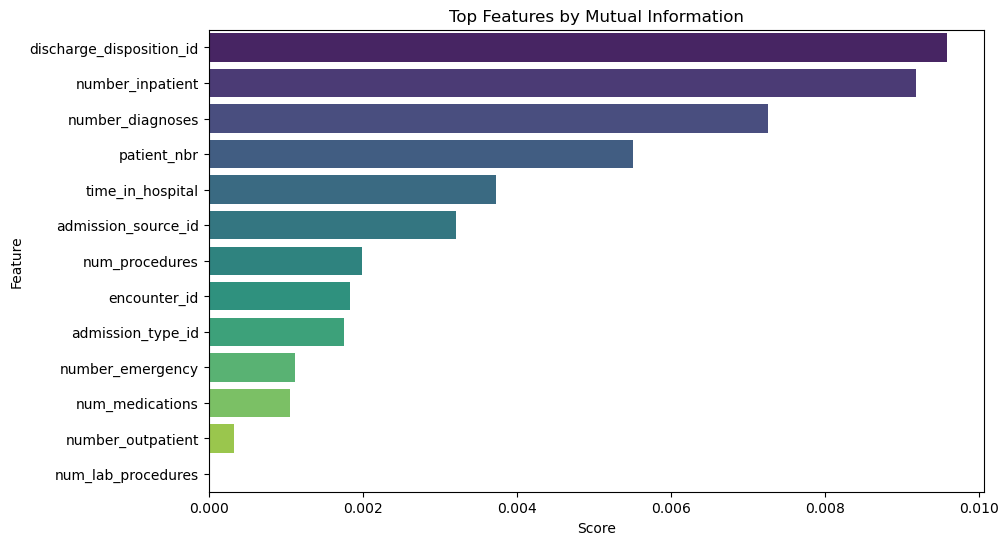

In [71]:
feature_scores = pd.Series(skb.scores_, index=X_train_vt.columns).sort_values(ascending=False)[:k]
plt.figure(figsize=(10,6))
sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")
plt.title("Top Features by Mutual Information")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()


## 7️⃣ Model Training & Evaluation

We train 4 models:
- Logistic Regression  
- Decision Tree  
- Random Forest  
- Gradient Boosting  

We evaluate them using Accuracy, Precision, Recall, and F1 Score.  



🚀 Training Logistic Regression...


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\m

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.00      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.44      0.50      0.47     15520
weighted avg       0.79      0.89      0.83     15520

--------------------------------------------------


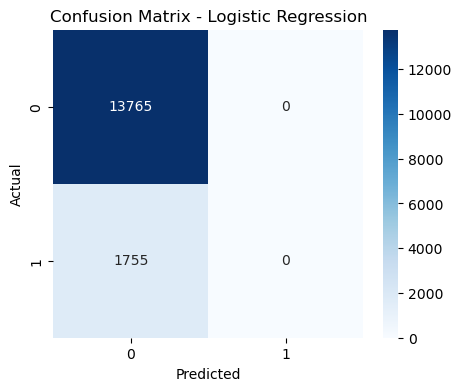


🚀 Training Decision Tree...
Decision Tree Results:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     13765
           1       0.17      0.19      0.18      1755

    accuracy                           0.80     15520
   macro avg       0.53      0.53      0.53     15520
weighted avg       0.81      0.80      0.81     15520

--------------------------------------------------


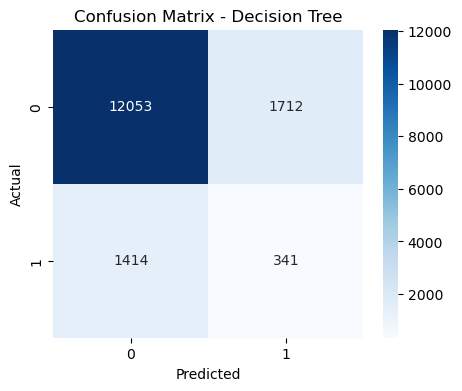


🚀 Training Random Forest...
Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.62      0.02      0.04      1755

    accuracy                           0.89     15520
   macro avg       0.75      0.51      0.49     15520
weighted avg       0.86      0.89      0.84     15520

--------------------------------------------------


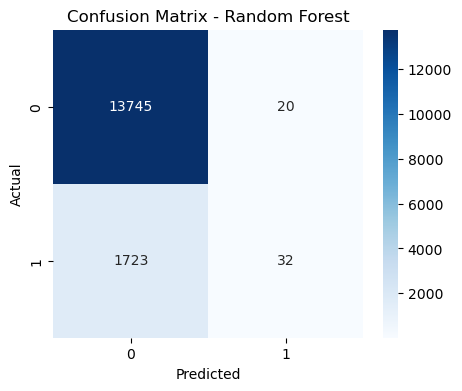


🚀 Training Gradient Boosting...
Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.59      0.01      0.03      1755

    accuracy                           0.89     15520
   macro avg       0.74      0.51      0.48     15520
weighted avg       0.85      0.89      0.84     15520

--------------------------------------------------


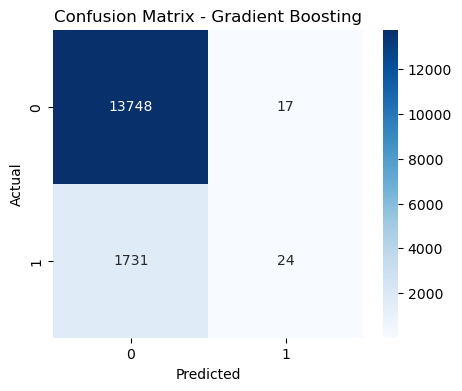

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 8️⃣ Results Summary

We now compare the performance of all models and find the best one based on **F1 Score**.



✅ Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score
1        Decision Tree  0.798582   0.166098  0.194302  0.179097
2        Random Forest  0.887693   0.615385  0.018234  0.035418
3    Gradient Boosting  0.887371   0.585366  0.013675  0.026726
0  Logistic Regression  0.886920   0.000000  0.000000  0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_14896\1460230740.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df, palette="mako")


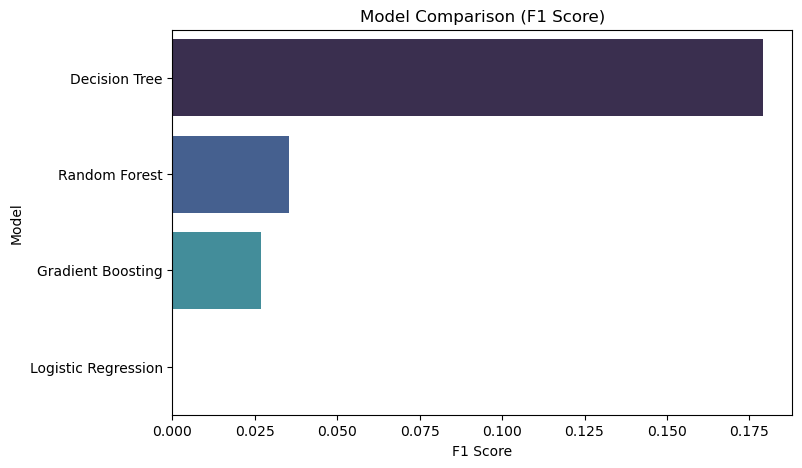

In [77]:
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n✅ Model Performance Summary:")
print(results_df)

plt.figure(figsize=(8,5))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="mako")
plt.title("Model Comparison (F1 Score)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.show()


## 🏆 Best Model Selection


In [80]:
# Find best model based on F1 Score
best_model = results_df.iloc[0]
print(f"🏆 Best Model: {best_model['Model']}")
print(f"✅ Accuracy: {best_model['Accuracy']:.4f}")
print(f"✅ Precision: {best_model['Precision']:.4f}")
print(f"✅ Recall: {best_model['Recall']:.4f}")
print(f"✅ F1 Score: {best_model['F1 Score']:.4f}")


🏆 Best Model: Decision Tree
✅ Accuracy: 0.7986
✅ Precision: 0.1661
✅ Recall: 0.1943
✅ F1 Score: 0.1791


# ✅ Conclusion

- Preprocessed the diabetic dataset, handled missing values, and performed feature selection.  
- Multiple ML models were trained and evaluated.  
- The **best model** selected based on the highest **F1 Score** is Decision Tree.
This helps hospitals identify patients at risk of **30-day readmission** and improve patient care.
